<a href="https://colab.research.google.com/github/MaggieLieu/MLiS_examples/blob/master/CNN_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural networks

In this notebook we will be building a convolutional neural network classifier using keras. First you should make sure you are running on GPU:

Runtime > Change runtime type > Hardware accelerator > GPU

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
%matplotlib inline
import matplotlib.pyplot as plt


TensorFlow 2.x selected.


Okay lets download a dataset. In the tensorflow_datasets package we have access to many well known machine learning datasets. See
https://www.tensorflow.org/datasets/catalog/overview
for the full list. Here we will download the MNIST dataset which contains images of handwritten numbers 0-9.

In [0]:
ds = tfds.load(name="mnist", as_supervised = True) #get mnist dataset 
train, test = ds["train"], ds["test"] #split train test

The data are already in test and train sets and we can see how much data is in each. We won't necessarily use all of this data later.



In [0]:
ntrain = len([image[0] for image in train])
ntest = len([image[0] for image in test])

print('Train sample: ', ntrain)
print('Test sample: ', ntest)

Train sample:  60000
Test sample:  10000


Let's take the first image from the train dataset and visualise it.

image 1 shape:  (28, 28, 1)


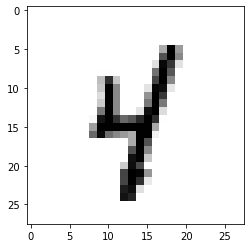

In [0]:
# take 1 image from train and convert to float64 and values 0-1
data1 = train.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).take(1)

#get first image data and label and plot it
features, labels = iter(data1).next()
print('image 1 shape: ', np.shape(features));
plt.imshow(features[:,:,0], cmap='gray_r');


You should see that we have an 28x28 grayscale image (1 channel) of the handwritten digit 8.

To give you a feel for what the convolutional layer does, we are now going to apply filters to this image.

Firstly we will apply a horizontal filter

$$\begin{bmatrix}
1 & 1 &  1 \\
0 & 0 & 0 \\
-1 & -1 & -1
\end{bmatrix}$$

This filter enhances the horizontal features of the image.

image shape:  (1, 26, 26, 1)


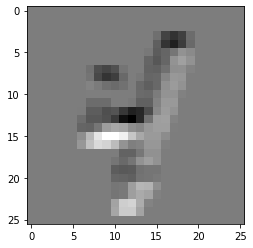

In [0]:
hor_filter = [[1,1,1],[0,0,0],[-1,-1,-1]]

#2D convolution 
output = tf.nn.conv2d(
      input=np.reshape(features, [1,28,28,1]), #batch, height, width, depth
      filters=np.reshape(hor_filter, [3,3,1,1]), #height, width, in_channels, out_channels
      strides=[1,1,1,1], 
      padding="VALID")
print('image shape: ', np.shape(output));
plt.imshow(output[0,:,:,0], cmap='gray');

The filter has extracted the features of horizontal edges in the image. Note that the image size has shrunk from 28x28 to 26x26.

Now lets try a vertical filter
$$\begin{bmatrix}
1 & 0 & -1 \\
1 & 0 & -1 \\
1 & 0 & -1
\end{bmatrix}$$

You should find that this filter extracts the vertical edges of the image.

image shape:  (1, 26, 26, 1)


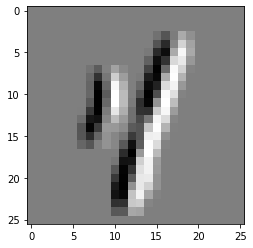

In [0]:
ver_filter = [[1,0,-1],[1,0,-1],[1,0,-1]]

output = tf.nn.conv2d(
      input=np.reshape(features, [1,28,28,1]),
      filters=np.reshape(ver_filter, [3,3,1,1]),
      strides=[1,1,1,1], #in batch, x, y, channel
      padding="VALID")
print('image shape: ', np.shape(output));
plt.imshow(output[0,:,:,0], cmap='gray');

A convolutional neural network consists of convolutional, pooling and fully connected layers. Let's look at these individually.